# Bayes Classifier Training - Optimized Pipeline

Train and evaluate a Naive Bayes classifier with optimized feature engineering:

## Optimized Feature Pipeline (52 → ~43 → 15):

### Base Features (52 total):
- **Color**: Mean & Std HSV (6 features)
- **Texture**: LBP histogram + Haralick (19 features)
- **Shape**: Aspect ratio + Hu moments (4 features)

### Material-Specific Features (7 total - optimized):
- **Specular (Metal)**: Highlight contrast, gradient concentration (2) - *reduced from 6*
- **Metal**: Reflection directionality (1) - *reduced from 2*
- **Glass**: Brightness gradient smoothness, high-freq FFT energy, saturation uniformity (3) - *reduced from 4, removed unstable Canny*
- **Trash**: Texture chaos (1) - *reduced from 4*

### Texture Features (16):
- **Single-scale LBP**: Radius=2 only (16 bins) - *multi-scale removed*

### Optimization Pipeline:
1. **Correlation Removal**: 52 → ~43 features (threshold=0.85)
2. **Scaling**: StandardScaler normalization
3. **PCA**: ~43 → 15 components (optimized)

### Model Configuration:
- **GaussianNB** with balanced priors (1/6 per class)
- **No OVR**: Standard multi-class (faster, simpler)
- **No Box-Cox**: Disabled (conflicts with some features)

This optimized pipeline targets improved generalization and reduced overfitting.

In [1]:
import sys
sys.path.append('..')

from src.config import load_config
from src.load_data import load_data
from src.models.bayes import BayesClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path


In [2]:
# Load configuration
config = load_config()

print("Configuration:")
print(f"  Dataset: {config['data']['dataset_name']}")
print(f"  Classes: {', '.join(config['data']['classes'])}")
print(f"  Image size: {config['data']['image_size']}x{config['data']['image_size']}")
print(f"\nFeature extraction:")
print(f"  LBP bins: {config['bayes']['lbp_bins']}")
print(f"  Use balanced priors: {config['bayes']['use_balanced_priors']}")
print(f"  Use OVR ensemble: {config['bayes']['use_ovr']}")
print(f"\nFeature optimization:")
print(f"  Remove correlated: {config['bayes']['remove_correlated']}")
if config['bayes']['remove_correlated']:
    print(f"  Correlation threshold: {config['bayes']['correlation_threshold']}")
print(f"  Use PCA: {config['bayes']['apply_pca']}")
if config['bayes']['apply_pca']:
    print(f"  PCA components: {config['bayes']['pca_components']}")
print(f"\n  Optimized feature breakdown:")
print(f"    Color (HSV mean + std): 6")
print(f"    Texture (LBP + Haralick): 19")
print(f"    Shape (aspect + Hu): 4")
print(f"    Specular (optimized): 2")
print(f"    Metal (optimized): 1")
print(f"    Glass (optimized): 3")
print(f"    Trash (optimized): 1")
print(f"    Single-scale LBP (r=2): 16")
print("    -----------------------------")
print(f"    Base total: 52 features")
if config['bayes']['remove_correlated']:
    print(f"    After correlation removal: ~43 features")
if config['bayes']['apply_pca']:
    print(f"    After PCA: {config['bayes']['pca_components']} features")


Configuration:
  Dataset: garythung/trashnet
  Classes: cardboard, glass, metal, paper, plastic, trash
  Image size: 224x224

Feature extraction:
  LBP bins: 16
  Single-scale LBP only: True
  Use balanced priors: True
  Use OVR ensemble: False

Feature optimization:
  Remove correlated: True
  Correlation threshold: 0.85
  Use PCA: True
  PCA components: 15

  Optimized feature breakdown:
    Color (HSV mean + std): 6
    Texture (LBP + Haralick): 19
    Shape (aspect + Hu): 4
    Specular (optimized): 2
    Metal (optimized): 1
    Glass (optimized): 3
    Trash (optimized): 1
    Single-scale LBP (r=2): 16
    ─────────────────────────────
    Base total: 52 features
    After correlation removal: ~43 features
    After PCA: 15 features


In [3]:
print("Loading datasets...")
train_dataset, val_dataset, test_dataset = load_data(split_data=True)

print(f"\nDataset sizes:")
print(f"  Training:   {len(train_dataset)} images")
print(f"  Validation: {len(val_dataset)} images")
print(f"  Test:       {len(test_dataset)} images")


Loading datasets...

Dataset sizes:
  Training:   3537 images
  Validation: 758 images
  Test:       759 images


## Feature Extraction Visualization

Let's visualize what features we're extracting from a sample image.

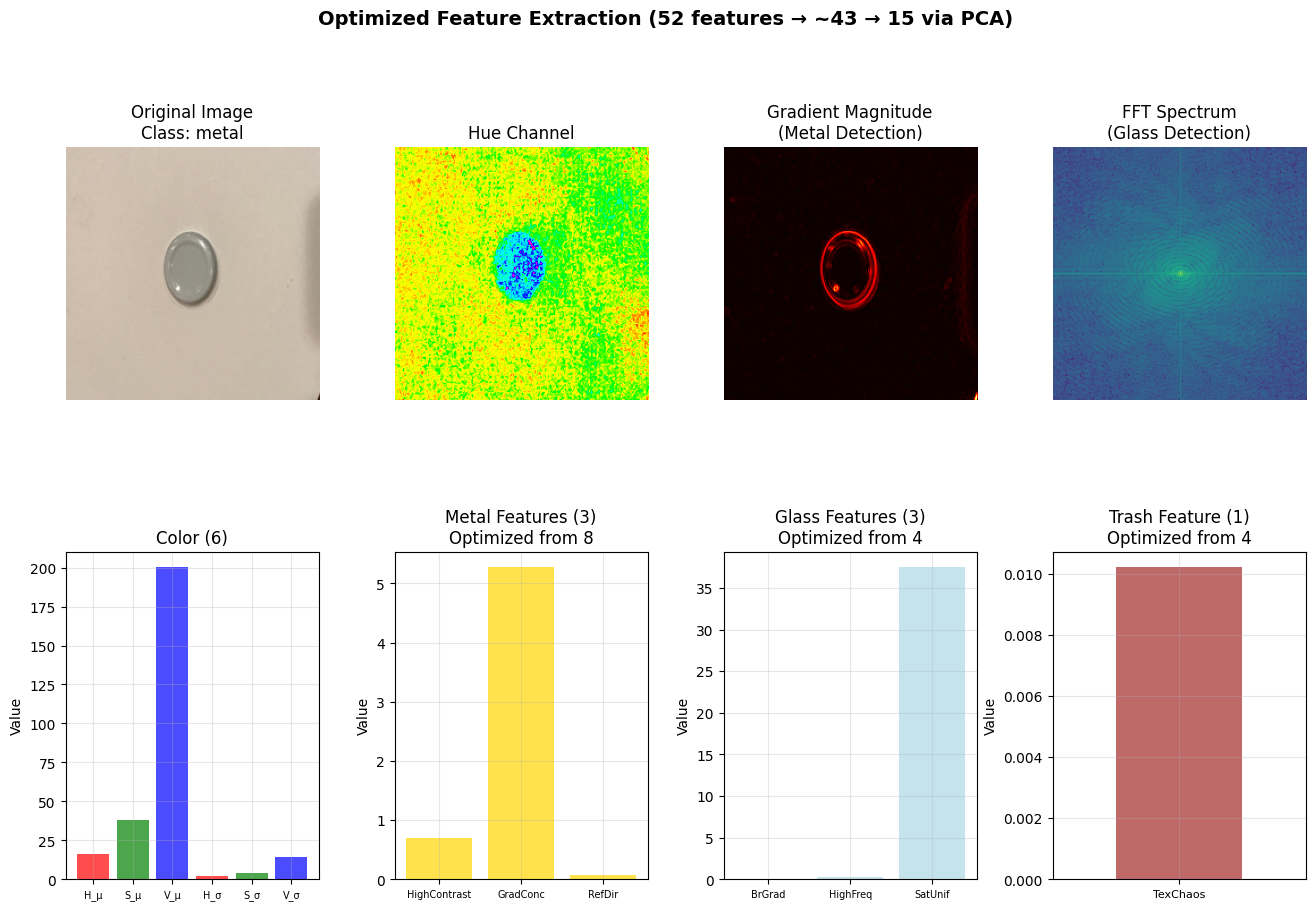


OPTIMIZED Feature Breakdown:
  Color (HSV): 6 features
  Texture (LBP + Haralick): 19 features
  Shape (aspect + Hu): 4 features
  Specular (optimized): 2 features (was 6)
  Metal (optimized): 1 features (was 2)
  Glass (optimized): 3 features (was 4)
  Trash (optimized): 1 features (was 4)
  ─────────────────────────────────────
  TOTAL EXTRACTED: 52 features
  After correlation removal: ~43 features
  After PCA: 15 features

Key optimized feature values for 'metal':
  Metal - Highlight contrast: 0.6916
  Metal - Gradient concentration: 5.2733
  Metal - Reflection directionality: 0.0692
  Glass - Brightness gradient: 0.0442
  Glass - High-freq energy: 0.2357
  Glass - Saturation uniformity: 37.4812
  Trash - Texture chaos: 0.0102


In [4]:
from src.models.bayes import BayesFeatureExtractor
import cv2

# Create feature extractor
feature_extractor = BayesFeatureExtractor(config)

# Get a sample image
sample = train_dataset[0]
sample_image = sample['image']
sample_label = sample['label']
class_name = config['data']['classes'][sample_label]

# Resize to standard size
sample_image_resized = sample_image.resize((config['data']['image_size'], config['data']['image_size']))
sample_array = np.array(sample_image_resized)

# Extract individual feature groups (OPTIMIZED VERSIONS)
color_feat = feature_extractor.extract_color_features(sample_image_resized)
texture_feat = feature_extractor.extract_texture_features(sample_image_resized)
shape_feat = feature_extractor.extract_shape_features(sample_image_resized)
specular_feat = feature_extractor.extract_specular_features(sample_image_resized)  # 2 features (optimized)
metal_feat = feature_extractor.extract_metal_features(sample_image_resized)        # 1 feature (optimized)
glass_feat = feature_extractor.extract_glass_features(sample_image_resized)        # 3 features (optimized)
trash_feat = feature_extractor.extract_trash_features(sample_image_resized)        # 1 feature (optimized)
all_features = feature_extractor.extract_features(sample_image_resized)

# Convert to HSV for visualization
hsv = cv2.cvtColor(sample_array, cv2.COLOR_RGB2HSV)

# Plot
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 4, hspace=0.35, wspace=0.3)

# Row 1: Images
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(sample_image_resized)
ax1.set_title(f'Original Image\nClass: {class_name}')
ax1.axis('off')

ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(hsv[:, :, 0], cmap='hsv')
ax2.set_title('Hue Channel')
ax2.axis('off')

ax3 = fig.add_subplot(gs[0, 2])
# Gradient magnitude for metal detection
gray = cv2.cvtColor(sample_array, cv2.COLOR_RGB2GRAY)
grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
grad_magnitude = np.sqrt(grad_x**2 + grad_y**2)
ax3.imshow(grad_magnitude, cmap='hot')
ax3.set_title('Gradient Magnitude\n(Metal Detection)')
ax3.axis('off')

ax4 = fig.add_subplot(gs[0, 3])
# FFT for glass detection
f_transform = np.fft.fft2(gray)
f_shift = np.fft.fftshift(f_transform)
magnitude = np.log(np.abs(f_shift) + 1)
ax4.imshow(magnitude, cmap='viridis')
ax4.set_title('FFT Spectrum\n(Glass Detection)')
ax4.axis('off')

# Row 2: Optimized feature visualizations
ax5 = fig.add_subplot(gs[1, 0])
ax5.bar(range(6), color_feat, color=['red', 'green', 'blue', 'red', 'green', 'blue'], alpha=0.7)
ax5.set_xticks(range(6))
ax5.set_xticklabels(['H_mu', 'S_mu', 'V_mu', 'H_sigma', 'S_sigma', 'V_sigma'], fontsize=7)
ax5.set_title('Color (6)')
ax5.set_ylabel('Value')
ax5.grid(alpha=0.3)

ax6 = fig.add_subplot(gs[1, 1])
metal_combined = np.concatenate([specular_feat, metal_feat])  # 2 + 1 = 3 total
ax6.bar(range(3), metal_combined, color='gold', alpha=0.7)
ax6.set_xticks(range(3))
ax6.set_xticklabels(['HighContrast', 'GradConc', 'RefDir'], fontsize=7)
ax6.set_title('Metal Features (3)\nOptimized from 8')
ax6.set_ylabel('Value')
ax6.grid(alpha=0.3)

ax7 = fig.add_subplot(gs[1, 2])
ax7.bar(range(3), glass_feat, color='lightblue', alpha=0.7)
ax7.set_xticks(range(3))
ax7.set_xticklabels(['BrGrad', 'HighFreq', 'SatUnif'], fontsize=7)
ax7.set_title('Glass Features (3)\nOptimized from 4')
ax7.set_ylabel('Value')
ax7.grid(alpha=0.3)

ax8 = fig.add_subplot(gs[1, 3])
ax8.bar([0], trash_feat, color='brown', alpha=0.7, width=0.5)
ax8.set_xticks([0])
ax8.set_xticklabels(['TexChaos'], fontsize=8)
ax8.set_title('Trash Feature (1)\nOptimized from 4')
ax8.set_ylabel('Value')
ax8.set_xlim(-0.5, 0.5)
ax8.grid(alpha=0.3)

plt.suptitle('Optimized Feature Extraction (52 features -> ~43 -> 15 via PCA)', 
             fontsize=14, fontweight='bold')
plt.show()

print(f"\n{'='*70}")
print("OPTIMIZED Feature Breakdown:")
print(f"{'='*70}")
print(f"  Color (HSV): {len(color_feat)} features")
print(f"  Texture (LBP + Haralick): {len(texture_feat)} features")
print(f"  Shape (aspect + Hu): {len(shape_feat)} features")
print(f"  Specular (optimized): {len(specular_feat)} features (was 6)")
print(f"  Metal (optimized): {len(metal_feat)} features (was 2)")
print(f"  Glass (optimized): {len(glass_feat)} features (was 4)")
print(f"  Trash (optimized): {len(trash_feat)} features (was 4)")
print("  ------------------------------")
print(f"  TOTAL EXTRACTED: {len(all_features)} features")
print(f"  After correlation removal: ~43 features")
print(f"  After PCA: {config['bayes']['pca_components']} features")
print(f"{'='*70}")
print(f"\nKey optimized feature values for '{class_name}':")
print(f"  Metal - Highlight contrast: {specular_feat[0]:.4f}")
print(f"  Metal - Gradient concentration: {specular_feat[1]:.4f}")
print(f"  Metal - Reflection directionality: {metal_feat[0]:.4f}")
print(f"  Glass - Brightness gradient: {glass_feat[0]:.4f}")
print(f"  Glass - High-freq energy: {glass_feat[1]:.4f}")
print(f"  Glass - Saturation uniformity: {glass_feat[2]:.4f}")
print(f"  Trash - Texture chaos: {trash_feat[0]:.4f}")


## Data Augmentation Visualization

Before training, let's see how data augmentation transforms the images.

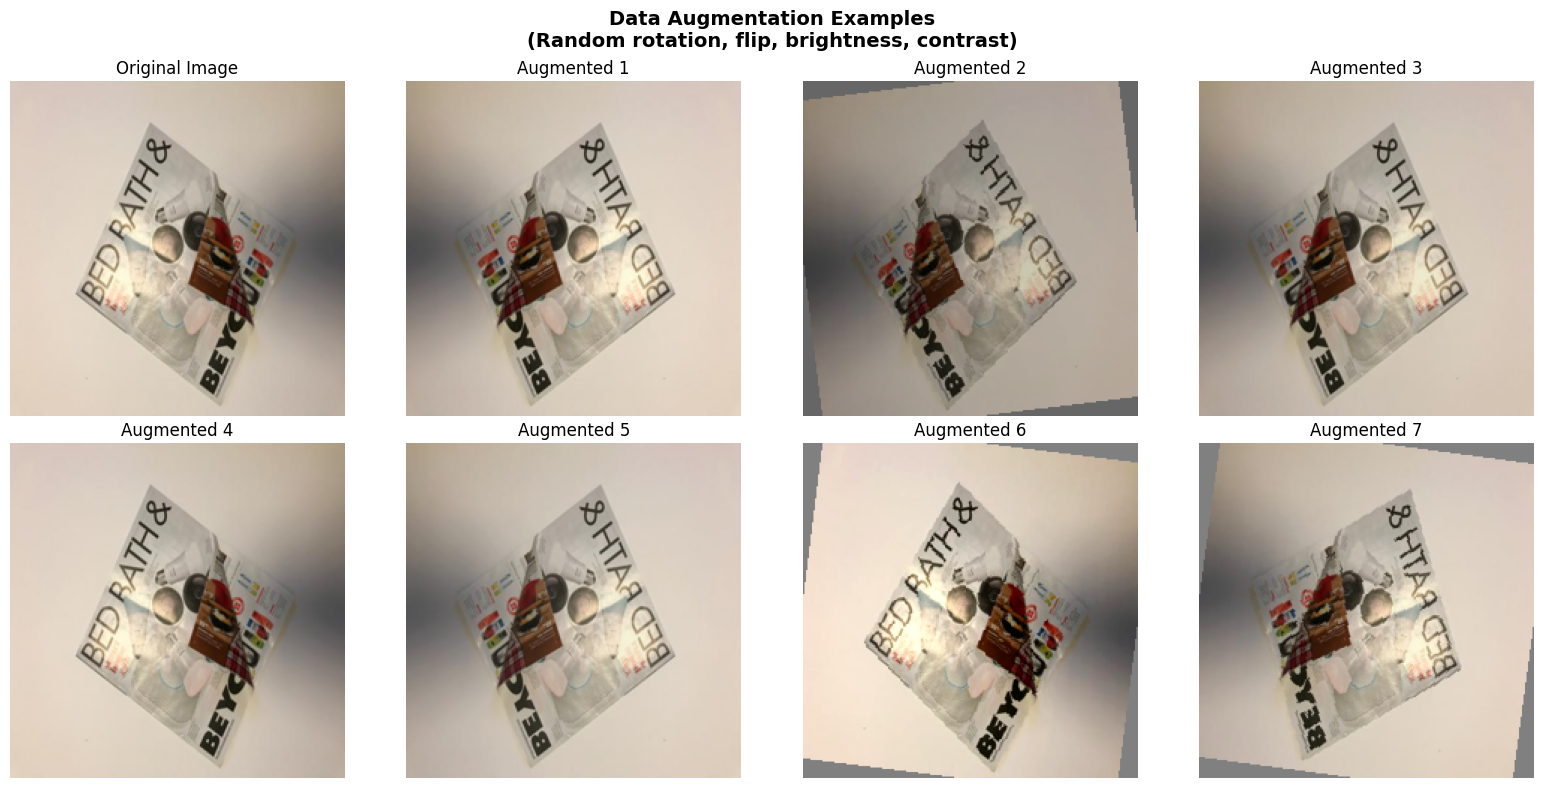

Each training image will be augmented 2 times, tripling the effective dataset size.
Original: 3537 -> With augmentation: 10611


In [5]:
# Visualize augmentation on a sample image
from src.models.bayes import BayesFeatureExtractor

feature_extractor = BayesFeatureExtractor(config)

# Get a sample
sample = train_dataset[100]
sample_image = sample['image'].resize((config['data']['image_size'], config['data']['image_size']))

# Generate augmented versions
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

# Original
axes[0].imshow(sample_image)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Show 7 augmented versions
for i in range(1, 8):
    aug_image = feature_extractor.augment_image(sample_image)
    axes[i].imshow(aug_image)
    axes[i].set_title(f'Augmented {i}')
    axes[i].axis('off')

plt.suptitle('Data Augmentation Examples\n(Random rotation, flip, brightness, contrast)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Each training image will be augmented 2 times, tripling the effective dataset size.")
print(f"Original: {len(train_dataset)} -> With augmentation: {len(train_dataset) * 3}")


## Train Bayes Classifier

In [6]:
# Initialize classifier with balanced priors
use_balanced = config['bayes']['use_balanced_priors']
use_augmentation = config['augmentation']['enabled']
augment_factor = 2  # Create 2 augmented versions per image

print(f"Initializing Bayes Classifier...")
print(f"  Balanced priors: {use_balanced}")
print(f"  Data augmentation: {use_augmentation}")
if use_augmentation:
    print(f"  Augmentation factor: {augment_factor}")
    print(f"  This will triple the training data: {len(train_dataset)} -> {len(train_dataset) * (1 + augment_factor)}\n")

classifier = BayesClassifier(config, use_balanced_priors=use_balanced)

# Train on training dataset with augmentation
classifier.fit(train_dataset, verbose=True, use_augmentation=use_augmentation, augment_factor=augment_factor)


Initializing Bayes Classifier...
  Balanced priors: True
  Data augmentation: False
Extracting features from training data...


Training features:   0%|          | 0/3537 [00:00<?, ?it/s]

Training features: 100%|██████████| 3537/3537 [09:26<00:00,  6.24it/s]

Feature shape: (3537, 52)
Removing correlated features (threshold=0.85)...
  Removing zero-variance features before correlation analysis...
  Removed 16 correlated features
  Features: 52 → 29 (removed 23 total)
Standardizing features...
Applying PCA (reducing to 15 components)...
  Variance explained: 93.41%
Training GaussianNB classifier...
  Final feature shape: (3537, 15)
Training complete!
Training accuracy: 0.5824


## Evaluate on Validation Set

In [7]:
# Evaluate on validation set and log predictions
from pathlib import Path

log_dir = Path(config["paths"]["logs_dir"])
log_dir.mkdir(parents=True, exist_ok=True)
val_log_file = log_dir / "validation_predictions.txt"

print(f"\nEvaluating on validation set...")
print(f"Logging predictions to {val_log_file}")
val_results = classifier.evaluate(val_dataset, verbose=True, log_predictions=True, log_file=val_log_file)



Evaluating on validation set...
Logging predictions to logs\validation_predictions.txt


Extracting features for evaluation: 100%|██████████| 758/758 [02:03<00:00,  6.16it/s]

Predictions logged to: logs\validation_predictions.txt

Evaluation Results
Accuracy:  0.5633
Precision: 0.5951
Recall:    0.5633
F1 Score:  0.5725

Per-class metrics:
Class        |  Precision |     Recall |         F1 |  Support
-------------+------------+------------+------------+---------
cardboard    |     0.8851 |     0.7000 |     0.7817 |      110
glass        |     0.5031 |     0.5594 |     0.5298 |      143
metal        |     0.4045 |     0.3103 |     0.3512 |      116
paper        |     0.6497 |     0.6845 |     0.6667 |      187
plastic      |     0.6403 |     0.5361 |     0.5836 |      166
trash        |     0.1954 |     0.4722 |     0.2764 |       36


## Evaluate on Test Set

In [8]:
# Evaluate on test set and log predictions
test_log_file = log_dir / "test_predictions.txt"

print(f"\nEvaluating on test set...")
print(f"Logging predictions to {test_log_file}")
test_results = classifier.evaluate(test_dataset, verbose=True, log_predictions=True, log_file=test_log_file)

print(f"\n All prediction logs saved to {log_dir}")
print(f"  - {val_log_file.name}")
print(f"  - {test_log_file.name}")



Evaluating on test set...
Logging predictions to logs\test_predictions.txt


Extracting features for evaluation: 100%|██████████| 759/759 [02:10<00:00,  5.80it/s]

Predictions logged to: logs\test_predictions.txt

Evaluation Results
Accuracy:  0.5995
Precision: 0.6253
Recall:    0.5995
F1 Score:  0.6091

Per-class metrics:
Class        |  Precision |     Recall |         F1 |  Support
-------------+------------+------------+------------+---------
cardboard    |     0.8557 |     0.7155 |     0.7793 |      116
glass        |     0.5120 |     0.5519 |     0.5312 |      154
metal        |     0.4833 |     0.4874 |     0.4854 |      119
paper        |     0.7198 |     0.7278 |     0.7238 |      180
plastic      |     0.6720 |     0.5563 |     0.6087 |      151
trash        |     0.2029 |     0.3590 |     0.2593 |       39

✓ All prediction logs saved to logs
  - validation_predictions.txt
  - test_predictions.txt


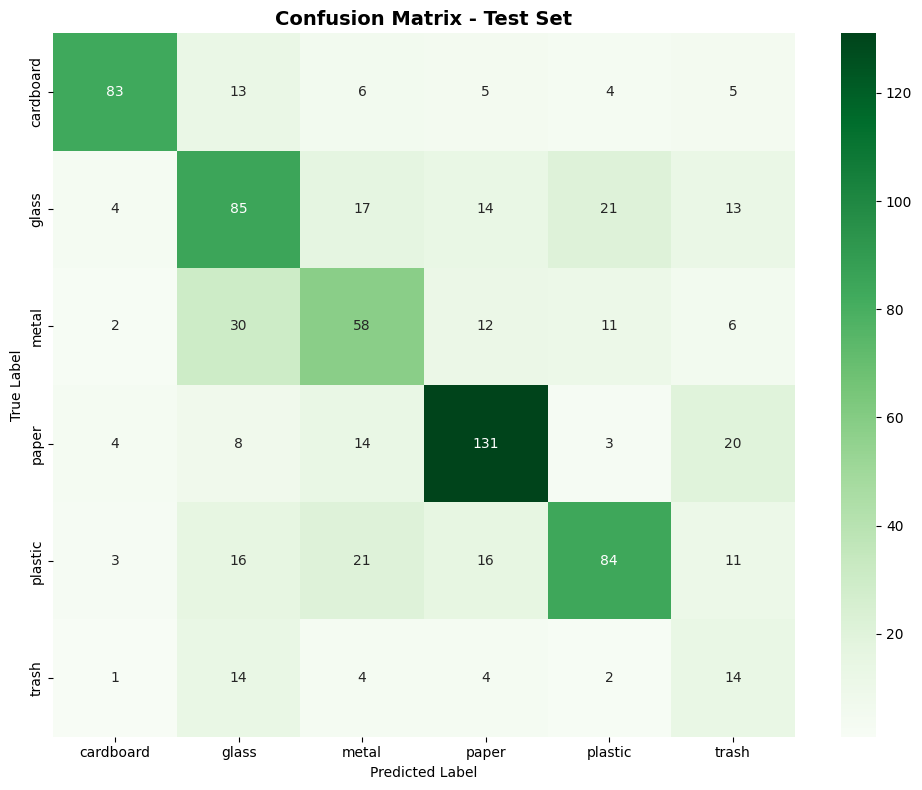


Per-class accuracy:
  cardboard   : 0.7155
  glass       : 0.5519
  metal       : 0.4874
  paper       : 0.7278
  plastic     : 0.5563
  trash       : 0.3590


In [9]:
# Plot confusion matrix for test set
cm_test = test_results['confusion_matrix']

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_test,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=config['data']['classes'],
    yticklabels=config['data']['classes']
)
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print("\nPer-class accuracy:")
for i, class_name in enumerate(config['data']['classes']):
    class_acc = cm_test[i, i] / cm_test[i].sum() if cm_test[i].sum() > 0 else 0
    print(f"  {class_name:<12}: {class_acc:.4f}")


## Compare Validation and Test Performance

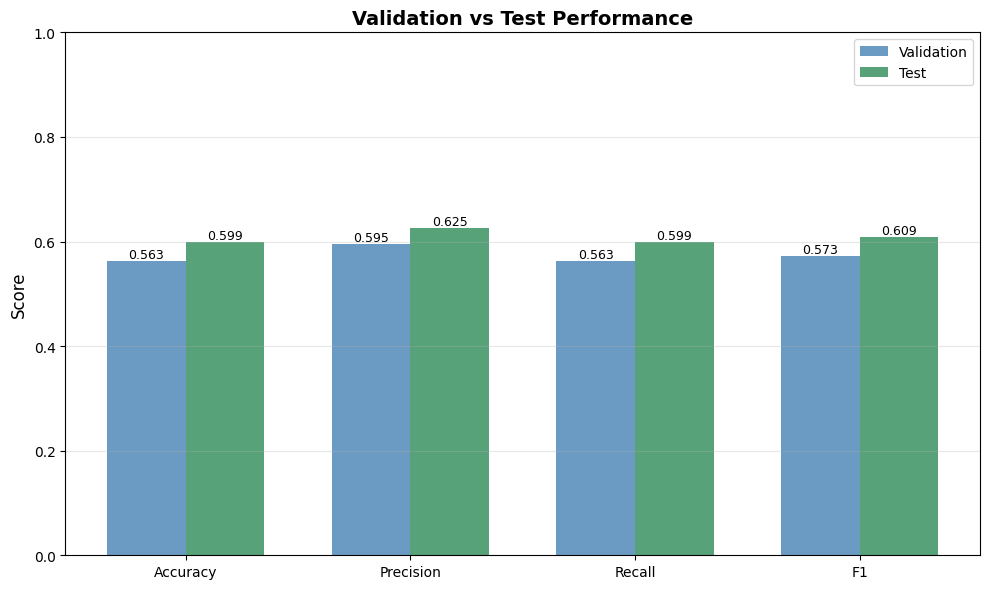


FINAL RESULTS SUMMARY

Metric       |   Validation |         Test
-------------+--------------+-------------
Accuracy     |       0.5633 |       0.5995
Precision    |       0.5951 |       0.6253
Recall       |       0.5633 |       0.5995
F1           |       0.5725 |       0.6091


In [10]:
# Compare metrics
metrics = ['accuracy', 'precision', 'recall', 'f1']

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(metrics))
width = 0.35

val_scores = [val_results[m] for m in metrics]
test_scores = [test_results[m] for m in metrics]

bars1 = ax.bar(x - width/2, val_scores, width, label='Validation', color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, test_scores, width, label='Test', color='seagreen', alpha=0.8)

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Validation vs Test Performance', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([m.capitalize() for m in metrics])
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print("FINAL RESULTS SUMMARY")
print(f"{'='*60}")
print(f"\n{'Metric':<12} | {'Validation':>12} | {'Test':>12}")
print(f"{'-'*12}-+-{'-'*12}-+-{'-'*12}")
for metric in metrics:
    print(f"{metric.capitalize():<12} | {val_results[metric]:>12.4f} | {test_results[metric]:>12.4f}")
print(f"{'='*60}")


## Save Model

In [11]:
# Create models directory and save
models_dir = Path(config['paths']['models_dir'])
models_dir.mkdir(parents=True, exist_ok=True)

model_path = models_dir / 'bayes_classifier.pkl'
classifier.save(model_path)

print(f"\nModel saved successfully!")
print(f"Path: {model_path}")


Model saved to models\bayes_classifier.pkl

Model saved successfully!
Path: models\bayes_classifier.pkl


## Feature Distribution Analysis

Analyze how features differ across waste classes to understand discriminative power.

Extracting optimized features from sample data...
  cardboard: 100 samples
  glass: 100 samples
  metal: 100 samples
  paper: 100 samples
  plastic: 100 samples
  trash: 100 samples

Extracted feature shape: (600, 52)


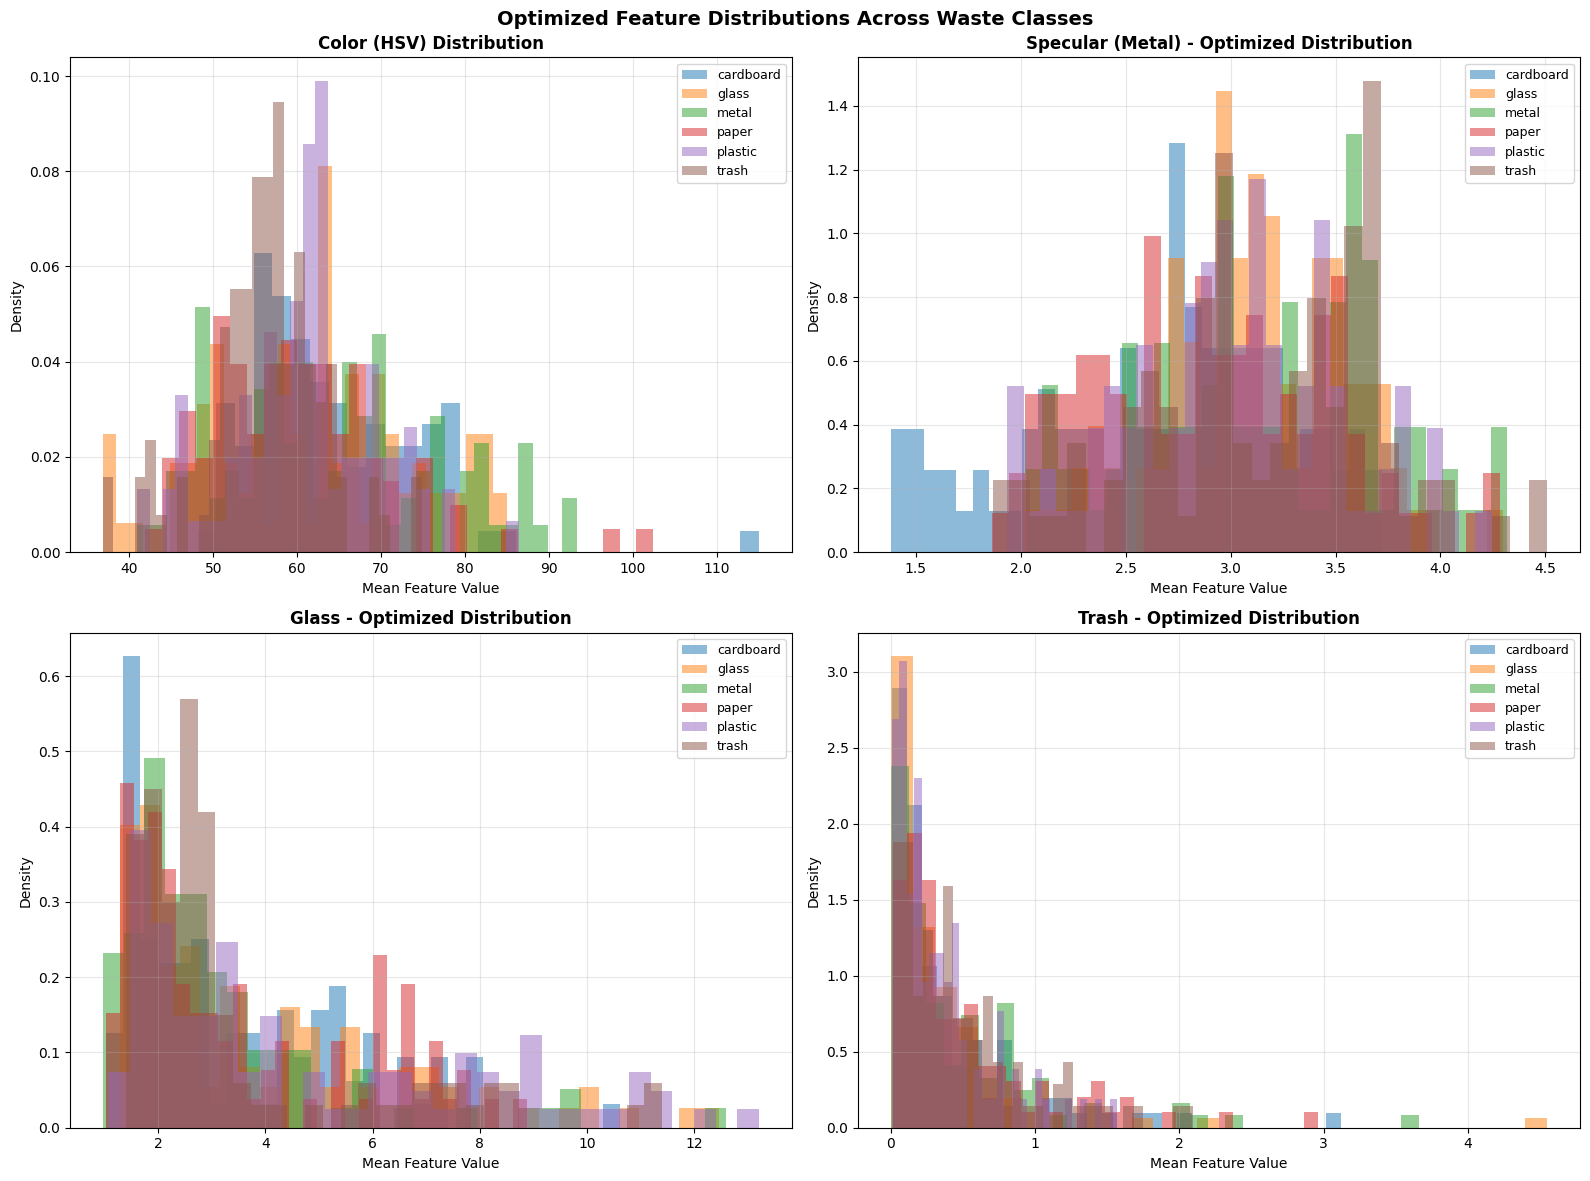


Per-Class Feature Statistics (Mean ± Std) - OPTIMIZED FEATURES

Color (HSV):
  cardboard   :  64.1643 ± 56.1920
  glass       :  61.9958 ± 59.1480
  metal       :  64.3251 ± 53.8003
  paper       :  59.9103 ± 54.3299
  plastic     :  61.0918 ± 59.2888
  trash       :  56.2750 ± 57.9969

Specular (Metal) - Optimized:
  cardboard   :   2.6594 ± 2.6788
  glass       :   3.1172 ± 3.1209
  metal       :   3.1563 ± 3.0926
  paper       :   2.9143 ± 2.9201
  plastic     :   3.0182 ± 3.0194
  trash       :   3.1739 ± 3.1320

Glass - Optimized:
  cardboard   :   3.5080 ± 5.9075
  glass       :   3.9589 ± 6.9924
  metal       :   3.1063 ± 5.4240
  paper       :   3.4393 ± 5.8571
  plastic     :   4.7855 ± 8.5191
  trash       :   3.4587 ± 6.1219

Trash - Optimized:
  cardboard   :   0.3914 ± 0.4968
  glass       :   0.3220 ± 0.5346
  metal       :   0.4903 ± 0.5789
  paper       :   0.5036 ± 0.5260
  plastic     :   0.3353 ± 0.3366
  trash       :   0.4985 ± 0.4567


In [12]:
# Extract features for a sample of training data to analyze distributions
from src.models.bayes import BayesFeatureExtractor

feature_extractor = BayesFeatureExtractor(config)

# Sample 100 images per class for analysis (to keep it fast)
sample_size_per_class = 100
sampled_features = []
sampled_labels = []

print("Extracting optimized features from sample data...")
for class_idx, class_name in enumerate(config["data"]["classes"]):
    count = 0
    for item in train_dataset:
        label = item["label"]
        if label == class_idx and count < sample_size_per_class:
            image = item["image"].resize((config["data"]["image_size"], config["data"]["image_size"]))
            features = feature_extractor.extract_features(image)
            sampled_features.append(features)
            sampled_labels.append(label)
            count += 1
        if count >= sample_size_per_class:
            break
    print(f"  {class_name}: {count} samples")

sampled_features = np.array(sampled_features)
sampled_labels = np.array(sampled_labels)

print(f"\nExtracted feature shape: {sampled_features.shape}")

# Updated feature indices for new 52-feature OPTIMIZED set
feature_groups = {
    "Color (HSV)": list(range(6)),
    "Specular (Metal) - Optimized": [29, 30],  # 2 features (was 6)
    "Glass - Optimized": [32, 33, 34],  # 3 features (was 4)
    "Trash - Optimized": [35]  # 1 feature (was 4)
}

# Plot distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for ax_idx, (group_name, feature_indices) in enumerate(feature_groups.items()):
    ax = axes[ax_idx]
    
    for class_idx, class_name in enumerate(config["data"]["classes"]):
        class_mask = sampled_labels == class_idx
        class_features = sampled_features[class_mask][:, feature_indices]
        mean_values = np.mean(class_features, axis=1)
        ax.hist(mean_values, bins=30, alpha=0.5, label=class_name, density=True)
    
    ax.set_title(f"{group_name} Distribution", fontsize=12, fontweight="bold")
    ax.set_xlabel("Mean Feature Value")
    ax.set_ylabel("Density")
    ax.legend(loc="best", fontsize=9)
    ax.grid(alpha=0.3)

plt.suptitle("Optimized Feature Distributions Across Waste Classes", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

# Print per-class statistics for key features
print(f"\n{'='*70}")
print("Per-Class Feature Statistics (Mean +/- Std) - OPTIMIZED FEATURES")
print(f"{'='*70}")
for feat_name, feat_indices in feature_groups.items():
    print(f"\n{feat_name}:")
    for class_idx, class_name in enumerate(config["data"]["classes"]):
        class_mask = sampled_labels == class_idx
        class_features = sampled_features[class_mask][:, feat_indices]
        mean_val = np.mean(class_features)
        std_val = np.std(class_features)
        print(f"  {class_name:<12}: {mean_val:>8.4f} +/- {std_val:.4f}")


## Feature Correlation Analysis

Identify highly correlated features that may be redundant.